# Robot Motion Model
!['Robot Motion'](robot.png)

# Motion equations
![title](motion_equations.png)

# State and control vectors
![title](state_and_control_vectors.png)

![title](DesignSystemModel)

In [13]:
"""Demonstration of jacobian calculation with Sympy"""
import sympy
import numpy as np
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
sympy.init_printing(use_latex="mathjax", fontsize='16pt')
time = symbols('t')
d = v* time
beta  = d / w * sympy.tan(alpha)
R = w / sympy.tan(alpha)

f_x_u = Matrix([[x - R*sympy.sin(theta) + R*sympy.sin(theta + beta)],
               [y + R*sympy.cos(theta) - R*sympy.cos(theta + beta)],
               [theta + beta]])
F = f_x_u.jacobian(Matrix([x,y,theta]))

R, beta = symbols('R,beta')
F = F.subs(w / sympy.tan(alpha), R)
F = F.subs( d / w * sympy.tan(alpha), beta)

"""This way of computation is useful when working with complicated equations 
or you want to double check it"""

F

⎡1  0  -R⋅cos(θ) + R⋅cos(β + θ)⎤
⎢                              ⎥
⎢0  1  -R⋅sin(θ) + R⋅sin(β + θ)⎥
⎢                              ⎥
⎣0  0             1            ⎦

# Now we will incorporate model and control noise
## Control covariance
![title](control_noise_covariance.png)

## Linearization for control matrix
![title](linearization_of_control_matrix.png)

In [2]:
"""Use Synmpy to calculate V"""

V = f_x_u.jacobian(Matrix([v,alpha]))

#Substitute some expressions with appropriate variables for simplicity
V = V.subs(sympy.tan(alpha) / w, 1/R)
V = V.subs(time*v/R, beta)
V = V.subs(time * v, 'd')
V

⎡                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅cos(β + θ)   w⋅⎝- tan (α) - 1⎠⋅sin(θ)   w⋅⎝- ta
⎢t⋅cos(β + θ)  ────────────────────────── - ──────────────────────── + ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅sin(β + θ)   w⋅⎝- tan (α) - 1⎠⋅cos(θ)   w⋅⎝- ta
⎢t⋅sin(β + θ)  ────────────────────────── + ──────────────────────── - ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                                                  ⎛

# Now we can perform predict step with these equations
![title](predict_step.png)

# Design the Measurement Model

![title](measurement_model.png)

In [3]:
p_x, p_y = symbols('p_x, p_y')

z = Matrix([[sympy.sqrt((p_x - x )**2 + (p_y - y )**2) ],
            [sympy.atan2( (p_y - y), (p_x - x) )- theta ]])

z.jacobian(Matrix([x, y, theta]))

⎡          -pₓ + x                      -p_y + y             ⎤
⎢───────────────────────────  ───────────────────────────  0 ⎥
⎢   ________________________     ________________________    ⎥
⎢  ╱         2            2     ╱         2            2     ⎥
⎢╲╱  (pₓ - x)  + (p_y - y)    ╲╱  (pₓ - x)  + (p_y - y)      ⎥
⎢                                                            ⎥
⎢       -(-p_y + y)                   -(pₓ - x)              ⎥
⎢  ──────────────────────       ──────────────────────     -1⎥
⎢          2            2               2            2       ⎥
⎣  (pₓ - x)  + (p_y - y)        (pₓ - x)  + (p_y - y)        ⎦

In [90]:
def Hj(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """

    p_x = landmark_pos[0]
    p_y = landmark_pos[1]
    dist2 = (p_x - x[0, 0])**2 + (p_y - x[1, 0])**2
    dist = np.sqrt(dist2)

    H = np.array(
        [[-(p_x - x[0, 0]) / dist, -(p_y - x[1, 0]) / dist, 0],
         [ (p_y - x[1, 0]) / dist2,  -(p_x - x[0, 0]) / dist2, -1]])
    return H

In [103]:
def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    p_x = landmark_pos[0]
    p_y = landmark_pos[1]
    dist = np.sqrt((p_x - x[0, 0])**2 + (p_y - x[1, 0])**2)

    Hx = np.array([[dist],
                [np.arctan2(p_y - x[1, 0], p_x - x[0, 0]) - x[2, 0]]])
    return Hx

In [104]:
import  numpy as np

def move(x,u,dt, wheelbase):
    """Simulate robot moving
       theta - initial position
       alpha - steering angle
       x - state vector
       u - control vector"""
    
    theta = x[2]
    alpha = u[1]
    velocity = u[0]
    distance = velocity * dt
    
    if alpha > 0.001:
        r = wheelbase / np.tan(alpha) 
        beta = distance / wheelbase * np.tan(alpha) 
        sin_theta, cos_theta = np.sin(theta), np.cos(theta)
        sin_theta_beta, cos_theta_beta = np.sin(theta + beta), np.cos(theta + beta)
        
        return x + np.array(-r * sin_theta + r * sin_theta_beta, r * cos_theta - r * sin_theta_beta, beta)
    else:
        return x + np.array(distance * sin_theta, distance * cos_theta, 0)

# Design Measurement Noise

![title](measurement_noise.png)

# Define Robot class

In [114]:
from filterpy.kalman import ExtendedKalmanFilter as EKF

class RobotEKF(EKF):
    def __init__(self,dt, wheelbase, std_vel, std_steer):
        
        EKF.__init__(self,3,2,2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer
        
        
        a,x,y,v,w,theta,time = symbols('a,x,y,v,w,theta,t')
        d = v*time
        beta = (d / w) * sympy.tan(a)
        r = w / sympy.tan(a)
        
        self.f_x_u = Matrix([[x - r*sympy.sin(theta) + r*sympy.sin(theta + beta)],
               [y + r*sympy.cos(theta) - r*sympy.cos(theta + beta)],
               [theta + beta]])
        
        
        self.f_j = self.f_x_u.jacobian(Matrix([x,y,theta]))
        self.v_j = self.f_x_u.jacobian(Matrix([v,a]))
        
        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, 
                     time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.a, self.theta = v, a, theta
        
    
    def predict(self,u=0):
        self.x = self.move(self.x, u, self.dt)
        
        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = np.array(self.f_j.evalf(subs=self.subs)).astype(float)
        V = np.array(self.v_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = np.array([[self.std_vel*u[0]**2, 0], 
                   [0, self.std_steer**2]])

        self.P = np.dot( np.dot(F, self.P), F.T ) + np.dot(np.dot(V, M),V.T )
    
    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius

            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)], 
                           [r*cos(hdg) - r*cos(hdg + beta)], 
                           [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)], 
                           [dist*sin(hdg)], 
                           [0]])
        return x + dx

In [115]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing 
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[1] > np.pi:             # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y
        

In [120]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt

dt = 1.0

def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + np.random.randn()*std_rng],
                  [a + np.random.randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian=Hj, Hx=Hx, 
               residual=residual,
               args=(landmark), hx_args=(landmark))
    
                
def run_localization(landmarks, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=10, ellipse_step=20, ylim=None):
    
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = np.array([[2, 6, .3]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = np.array([1.1, .01]) 

    plt.figure(figsize =(12,9))
    plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60)
    
    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='k', alpha=0.3)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = z_landmark(lmark, sim_pos,
                               std_range, std_bearing)
                ekf_update(ekf, z, lmark)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
                    std=6, facecolor='g', alpha=0.8)
    track = np.array(track)
    
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

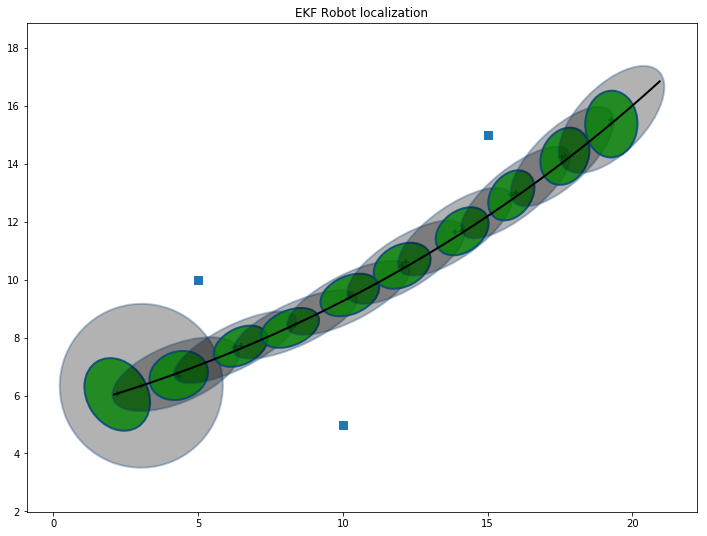

('Final P:', array([0.02486925, 0.04120071, 0.00220577]))


In [121]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())

Landmarks - solid squares. 
The path of the robot -  black line.
The covariance ellipses for the predict step - light gray.
The covariances of the update -  green.

We can see that there is a lot of uncertainty added by our motion model, and that most of the error in the direction of motion. We determine that from the shape of the blue ellipses. After a few steps we can see that the filter incorporates the landmark measurements and the errors decrease.

Now let's add another landmark.

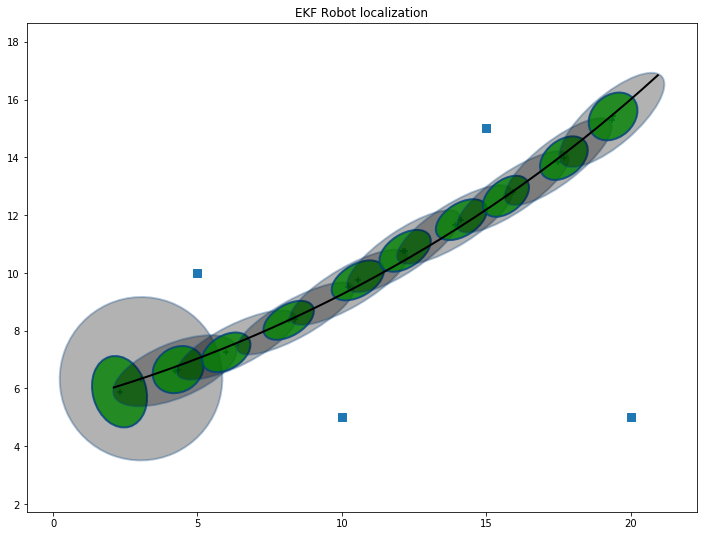

('Final P:', array([0.02016843, 0.02007407, 0.00153187]))


In [126]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
plt.show()
print('Final P:', ekf.P.diagonal())

The uncertainly in the estimates near the end of the track are smaller. We can see the effect that multiple landmarks have on our uncertainty by only using the first two landmarks.

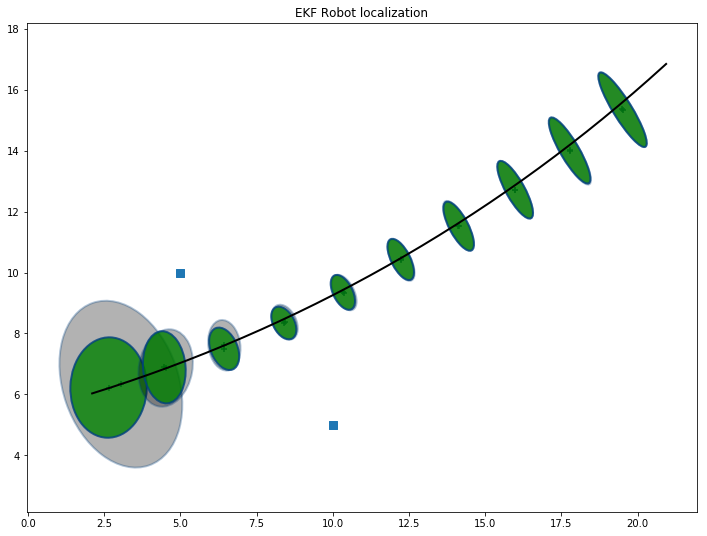

('Final P:', array([0.02017155, 0.04627498, 0.00022482]))


In [123]:
ekf = run_localization(
    landmarks[0:2], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

The estimate quickly diverges from the robot's path after passing the landmarks. The covariance also grows quickly. Let's see what happens with only one landmark:

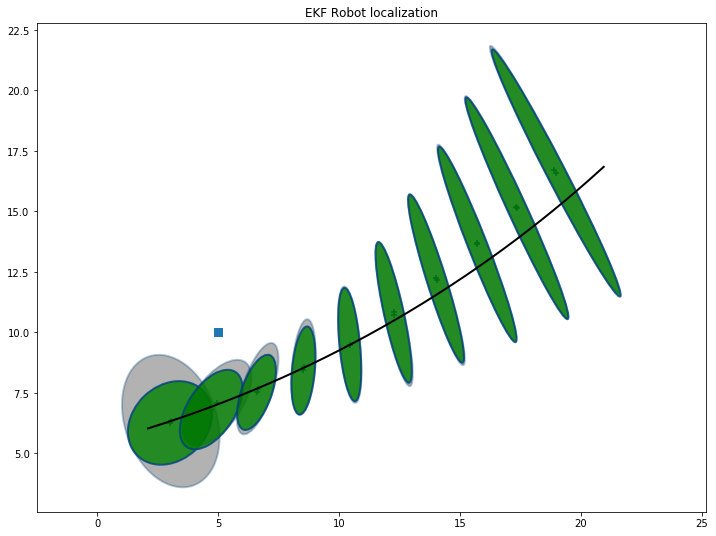

('Final P:', array([0.24042267, 0.79929393, 0.00349112]))


In [127]:
ekf = run_localization(
    landmarks[0:1], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

As you probably suspected, one landmark produces a very bad result. Conversely, a large number of landmarks allows us to make very accurate estimates:

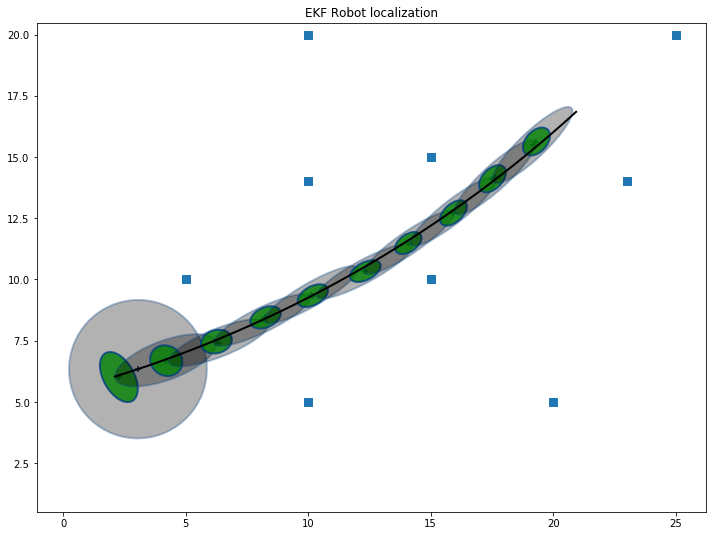

('Final P:', array([0.00839462, 0.00897055, 0.00076312]))


In [129]:
landmarks = np.array([[5, 10], [10,  5], [15, 15], [20,  5], [15, 10], 
                   [10,14], [23, 14], [25, 20], [10, 20]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1, ylim=(0, 21))
print('Final P:', ekf.P.diagonal())